In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, models, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit.visualization import *

# Preprocessing Dataset

## Move image into one folder
### Turn into code if needed

import shutil

IMAGE_PATH = 'C:/Users/10907026/Desktop/project/qiskit/cat_dog_dataset/'
train_cat_path = IMAGE_PATH + "cat/"
train_dog_path = IMAGE_PATH + "dog/"

if not os.path.isdir(IMAGE_PATH):
    os.mkdir(IMAGE_PATH)
if not os.path.isdir(train_cat_path):
    os.mkdir(train_cat_path)
if not os.path.isdir(train_dog_path):
    os.mkdir(train_dog_path)
    
ori_cat_path = 'C:/Users/10907026/Desktop/project/qiskit/dataset/cat/'
ori_dog_path = 'C:/Users/10907026/Desktop/project/qiskit/dataset/dog/'
cat_img = os.listdir(ori_cat_path)
dog_img = os.listdir(ori_dog_path)

for name in cat_img:
    shutil.copyfile(ori_cat_path + name, train_cat_path + name)
    
for name in dog_img:
    shutil.copyfile(ori_dog_path + name, train_dog_path + name)


## Loading Data

### Set 70% data for training and 30% data for testing

In [2]:
TRAIN_PATH = 'C:/Users/10907026/Desktop/project/qiskit/cat_dog_dataset'

data_transform = transforms.Compose([transforms.Resize([224,224]),
                                     transforms.ToTensor()])

X_train = datasets.ImageFolder(root=TRAIN_PATH, 
                               transform=data_transform)

train_size = int(0.7 * len(X_train))
test_size = len(X_train) - train_size
x_train, X_test = torch.utils.data.random_split(X_train, [train_size, test_size])

### Set Batch Size

In [3]:
b = 1

train_loader = torch.utils.data.DataLoader(X_train, batch_size=b, shuffle=True)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=b, shuffle=True)

# Setup Quantum Circuit

In [4]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        self._circuit.h(all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        job = qiskit.execute(self._circuit, 
                             self.backend, 
                             shots = self.shots,
                             parameter_binds = [{self.theta: theta} for theta in thetas])
        result = job.result().get_counts(self._circuit)
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

# Setup Hybrid Layer

In [5]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(4, backend, shots)   
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

# Create NN Module

Since image is RGB (3 channels), change Conv2d to 3

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=11)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(20000, 16)
        self.fc2 = nn.Linear(16, 1) # why????
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

# Start Training

In [7]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 10
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Training [10%]	Loss: 107.7523
Training [20%]	Loss: 135.8778
Training [30%]	Loss: 19.2690
Training [40%]	Loss: -0.6518
Training [50%]	Loss: -0.6656
Training [60%]	Loss: -0.6364
Training [70%]	Loss: -0.6678
Training [80%]	Loss: -0.6489
Training [90%]	Loss: -0.6597
Training [100%]	Loss: -0.6578


Text(0, 0.5, 'Neg Log Likelihood Loss')

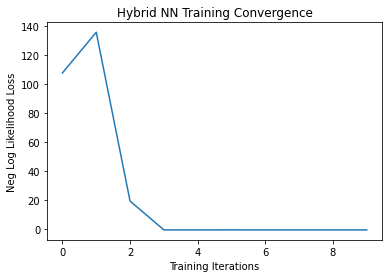

In [8]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

# Testing

In [9]:
model.eval()
with torch.no_grad():
    
    correct = 0
    val_total = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        val_total += data.size(0)
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / val_total * 100)
        )

Performance on test data:
	Loss: -0.6635
	Accuracy: 68.2%


In [10]:
print(correct)
print(val_total)
print(correct / val_total)

1513
2217
0.6824537663509247
